In [ ]:
# =============================================================================
# GRAIN BOUNDARY VELOCITY ANALYSIS - MISORIENTATION-ONLY ANISOTROPY (M)
# =============================================================================
# This notebook analyzes anti-curvature behavior in grain boundaries for
# systems with misorientation-dependent anisotropy ONLY (no inclination dependence).
# This is a simplified anisotropic case compared to the full MI analysis.
# 
# M = Misorientation-dependent anisotropy with texture parameter t=0.0
# This means grain boundary energy varies only with misorientation angle,
# not with crystallographic orientation of the boundary plane (inclination)

# Import required libraries and setup paths
import os
current_path = os.getcwd()  # Get current working directory for path management
import numpy as np
from numpy import seterr
seterr(all='raise')  # Set numpy to raise exceptions on all floating point errors (debugging)
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar for long-running loops
import sys

# Add necessary paths for importing custom modules
sys.path.append(current_path)  # Current directory
sys.path.append(current_path+'/../../')  # Parent directory for main modules
import myInput  # Custom input handling module
import PACKAGE_MP_Linear as linear2d  # 2D linear multi-physics package for grain boundary tracking
import post_processing  # Post-processing utilities for data analysis
sys.path.append(current_path+'/../calculate_tangent/')  # Path for tangent calculation utilities



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [ ]:
if __name__ == '__main__':
    # =============================================================================
    # DATA LOADING AND SETUP - MISORIENTATION-ONLY ANISOTROPY
    # =============================================================================
    
    # Define file paths for data storage and retrieval
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"  # Main data storage folder
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"  # SPPARKS anisotropic simulation results
    # Alternative path for isotropic comparison (commented out)
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    
    # Case configuration - MISORIENTATION-ONLY anisotropy
    case_name = "M_20k_fully"  # M = Misorientation-dependent only (no inclination effects)
    
    # Define file names for misorientation-only anisotropic data
    # Key parameter differences from MI case:
    # - "t0.0" = texture parameter is 0 (no inclination dependence)
    # - "f1.0" = misorientation parameter is 1 (full misorientation dependence)
    # This creates anisotropy that depends only on the misorientation angle between grains,
    # not on the crystallographic orientation of the boundary plane
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"  # M-anisotropic microstructure
    # Alternative isotropic file name (commented out for comparison)
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66_energy.npy"  # M-anisotropic energy
    # Alternative isotropic energy file name (commented out)
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Load misorientation-anisotropic microstructure data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)  # Load microstructure time evolution
    npy_file_aniso = npy_file_aniso.astype(int)  # Convert to integer grain IDs for processing
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    
    # Load corresponding misorientation-anisotropic energy data
    # Energy varies only with misorientation, creating simpler anisotropy than full MI case
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy)  # Load energy evolution
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    
    # Extract dimensions: time steps, spatial dimensions
    # In misorientation-only systems, energy landscape varies primarily with grain pair misorientations
    # This creates intermediate complexity between isotropic and full anisotropic cases
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
The M_20k_fully data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [ ]:
# =============================================================================
# SIMULATION MILESTONE TRACKING - MISORIENTATION-ONLY ANISOTROPY
# =============================================================================

# Define the time step when the system reaches approximately 1000 grains
# In misorientation-only anisotropic systems, grain growth rates are intermediate
# between isotropic and fully anisotropic cases due to:
# 1. Misorientation-dependent grain boundary energy
# 2. No inclination effects (simpler than full anisotropy)
# 3. Reduced complexity compared to MI systems
step_1000grains = 23  # Time step at which ~1000 grains remain (earlier than MI case)

In [ ]:
    # =============================================================================
    # GRAIN BOUNDARY CURVATURE CALCULATION - MISORIENTATION-ONLY ANISOTROPY
    # =============================================================================
    
    # Initialize parameters for GB analysis in misorientation-anisotropic systems
    step_num = 121  # Number of time steps to analyze
    grain_nums = 20000  # Total number of grains in the system
    GB_infomation_dict_list = []  # List to store GB information for each time step
    curvature_matrix_list = []  # List to store curvature matrices
    
    # Process each time step to extract GB information and calculate curvature
    # In misorientation-only systems, curvature calculation includes anisotropic effects
    # but without inclination dependence (simpler than full MI case)
    for time_step in tqdm(range(step_num)):
        # Define file names for cached data to avoid recomputation
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        
        # Try to load pre-computed data if available
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            # If pre-computed data doesn't exist, calculate from scratch
            current_microstructure = npy_file_aniso[time_step]
            
            # =============================================================================
            # SIGNED CURVATURE CALCULATION FOR MISORIENTATION-ANISOTROPIC SYSTEM
            # =============================================================================
            
            # Calculate signed curvature using the linear solver
            # For M-anisotropic systems, curvature reflects misorientation-dependent GB energy
            if os.path.exists(data_file_folder + data_curvature_file_name):
                # Load pre-computed curvature matrix
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                # Calculate curvature using the linear multi-physics solver
                cores = 128  # Number of CPU cores for parallel processing
                loop_times = 5  # Number of iterations for convergence
                R = np.zeros((size_x,size_y,3))  # Initialize reference array
                
                # Create smoothing class instance for curvature calculation
                # In M-anisotropic systems, the curvature accounts for misorientation-dependent energy
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")  # Run curvature calculation
                C_ln = smoothing_class.get_C()  # Get curvature results
                curvature_matrix = C_ln[1,:]  # Extract curvature matrix
                curvature_matrix_list.append(curvature_matrix)
                # Save curvature information for future use
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # =============================================================================
            # TRIPLE JUNCTION (TJ) AND QUADRUPLE JUNCTION (QJ) DETECTION
            # =============================================================================
            
            # Identify triple and quadruple junctions to exclude them from GB analysis
            # In misorientation-anisotropic systems, junctions can affect local energy landscape
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                # Get periodic boundary conditions for neighbors
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                
                # Check if current voxel is at a grain boundary
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    
                    central_site = int(current_microstructure[i,j,k])
                    
                    # Get all neighboring grain IDs
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list)  # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site)  # Remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # If more than 1 neighboring grain, this is a junction point
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m])  # Get pair ID
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:01<00:00, 111.39it/s]


In [ ]:
    # =============================================================================
    # GRAIN BOUNDARY ENERGY CALCULATION - MISORIENTATION-ONLY ANISOTROPY
    # =============================================================================
    
    # Similar to curvature calculation, but focused on extracting GB energy information
    # In M-anisotropic systems, energy varies only with misorientation (not inclination)
    step_num = 121  # Number of time steps to analyze
    grain_nums = 20000  # Total number of grains in the system
    GBenergy_information_dict_list = []  # Store GB energy information for each time step
    
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        
        # Try to load pre-computed energy data
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            # Calculate energy information from scratch
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]  # Load corresponding energy data

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:01<00:00, 105.59it/s]


In [ ]:
    # =============================================================================
    # VELOCITY CALCULATION FUNCTIONS AND MAIN PROCESSING
    # =============================================================================
    
    from numba import njit, prange
    import multiprocessing as mp
    
    # Optimized function to calculate volume change (dV) between time steps
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current, npy_file_aniso_next, pair_id_pair):
        """
        Calculate net volume change for a grain boundary between two time steps.
        
        Parameters:
        - npy_file_aniso_current: microstructure at current time step
        - npy_file_aniso_next: microstructure at next time step  
        - pair_id_pair: [grain_id1, grain_id2] for the grain boundary
        
        Returns:
        - Net volume change (positive = grain1 growing into grain2)
        """
        # Count voxels where grain1 grows into grain2
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        # Count voxels where grain2 grows into grain1
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    # Extended version that returns individual directional growth components
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current, npy_file_aniso_next, pair_id_pair):
        """
        Calculate volume change with separated directional components.
        
        Returns:
        - Net volume change, growth_direction1, growth_direction2
        """
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key, time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        """
        Compute GB velocity, curvature, energy, and anti-curvature behavior for one GB.
        
        Parameters:
        - key: GB identifier
        - time_interval: time between steps
        - GB_infomation_dict_list_one_step_one_key: GB curvature info
        - GBenergy_information_dict_list_one_step_one_key: GB energy info
        - npy_file_aniso_current/next: microstructures at current and next time steps
        
        Returns:
        - Dictionary with velocity, curvature, energy, and anti-curvature flag
        """
        # Calculate volume change and convert to velocity
        dV = compute_dV(npy_file_aniso_current, npy_file_aniso_next, GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV / time_interval / (GB_infomation_dict_list_one_step_one_key[5] / 2)  # Normalize by area and time
        
        # Extract curvature and energy values
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0  # Anti-curvature: opposite signs
        }
        
        return result
    
    def compute_necessary_info_split(key, time_interval,
                                   GB_infomation_dict_list_one_step_one_key,
                                   GBenergy_information_dict_list_one_step_one_key,
                                   npy_file_aniso_current,
                                   npy_file_aniso_next):
        """
        Extended version that includes directional growth components.
        """
        # Calculate volume change with directional split
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current, npy_file_aniso_next, 
                                                            GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV / time_interval / (GB_infomation_dict_list_one_step_one_key[5] / 2)
        
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,  # Growth of grain1 into grain2
            "dV_direction2": dV_direction2,  # Growth of grain2 into grain1
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    # =============================================================================
    # MAIN VELOCITY ANALYSIS LOOP
    # =============================================================================
    
    # Analysis parameters
    time_interval = 30  # Time interval between steps
    curvature_limit = 0.0182  # Minimum curvature threshold for analysis
    area_limit = 100  # Minimum GB area threshold
    
    # Initialize storage arrays for all GB data
    GB_list_velocity_list = []  # Store velocities for each time step
    GB_list_curvature_list = []  # Store curvatures for each time step
    GB_list_GBenergy_list = []  # Store energies for each time step
    GB_list_area_list = []  # Store areas for each time step
    GB_list_dV_direction1 = []  # Store directional growth data
    GB_list_dV_direction2 = []
    
    # Track anti-curvature GBs specifically
    GB_id_focus = dict()  # Count of anti-curvature occurrences per GB
    GB_id_focus_detail = dict()  # Detailed time step records per GB
    GB_filter_kernel = [set(), set(), set(), set(), set()]  # 5-step sliding window filter
    dV_dict = []  # Store all computed results
    
    # Process each time step to calculate velocities and identify anti-curvature behavior
    for time_step in range(step_num):
        if time_step + 1 >= step_num: 
            continue  # Skip last step (no next step for velocity calculation)
        
        # Initialize temporary storage for current time step
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # =============================================================================
        # FILTERING: Remove unsuitable GBs for analysis
        # =============================================================================
        
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        
        # Filter GBs based on area, persistence, and curvature criteria
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < area_limit or  # Too small area
                GB_infomation_dict_list[time_step + 1].get(key) is None or  # Disappears in next step
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit):  # Too low curvature
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        
        # =============================================================================
        # VELOCITY CALCULATION WITH CACHING
        # =============================================================================
        
        # Try to load pre-computed velocity data
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name, allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp = dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        
        # Calculate or retrieve velocity data for each GB
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]  # Use cached result
            else:
                # Compute new result
                result = compute_necessary_info_split(
                    key, time_interval,
                    tmp_GB_infomation_dict_for_mp[key],
                    tmp_GBenergy_information_dict_for_mp[key],
                    npy_file_aniso[time_step],
                    npy_file_aniso[time_step + 1]
                )
                dV_dict_tmp[key] = result
            
            # Store results for all GBs
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # Calculate and store GB area
            current_GB_area = 0.5 * tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)

            # =============================================================================
            # ANTI-CURVATURE TRACKING
            # =============================================================================
            
            # Track GBs showing anti-curvature behavior
            if result["is_anti_curvature"]:
                key_set.add(key)
                if time_step >= step_num - 3: 
                    continue  # Skip near end of simulation
                if key in GB_id_focus:
                    GB_id_focus[key] += 1  # Increment anti-curvature count
                    GB_id_focus_detail[key].append(time_step)
                else:
                    GB_id_focus[key] = 1  # First anti-curvature occurrence
                    GB_id_focus_detail[key] = [time_step]
        
        # Save computed data if not already cached
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)
            # pass
        
        # Store results for current time step
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        # =============================================================================
        # SLIDING WINDOW FILTER FOR ANTI-CURVATURE BEHAVIOR
        # =============================================================================
        
        # Update sliding window filter (5-step window)
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        
        # Apply "00100" filter: anti-curvature at step 2, normal at steps 0,1,3,4
        # This filters out random/transient anti-curvature behavior
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0] | GB_filter_kernel[1] | 
                                             GB_filter_kernel[3] | GB_filter_kernel[4])
        
        # Remove filtered GBs from tracking
        for key in filtered_set:
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step - 2)
        
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")

    # =============================================================================
    # FINAL FILTERING: Remove GBs with insufficient anti-curvature behavior
    # =============================================================================
    
    # Remove GBs that don't show consistent anti-curvature behavior
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <= 0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

key num start with 22827
key num end with 0


0it [00:00, ?it/s]


finish 0 with num of GBs 0, and collected num of GBs 0
key num start with 17980
key num end with 0


0it [00:00, ?it/s]


finish 1 with num of GBs 0, and collected num of GBs 0
key num start with 15113
key num end with 0


0it [00:00, ?it/s]


finish 2 with num of GBs 0, and collected num of GBs 0
key num start with 12583
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 97921.49it/s]


finish 3 with num of GBs 6, and collected num of GBs 0
key num start with 10819
key num end with 15


100%|██████████| 15/15 [00:00<00:00, 199728.76it/s]


finish 4 with num of GBs 15, and collected num of GBs 3
key num start with 9392
key num end with 20


100%|██████████| 20/20 [00:00<00:00, 201649.23it/s]


finish 5 with num of GBs 20, and collected num of GBs 6
key num start with 8408
key num end with 22


100%|██████████| 22/22 [00:00<00:00, 248050.24it/s]


finish 6 with num of GBs 22, and collected num of GBs 12
key num start with 7568
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 267721.53it/s]


finish 7 with num of GBs 27, and collected num of GBs 13
key num start with 6808
key num end with 31


100%|██████████| 31/31 [00:00<00:00, 301678.48it/s]


finish 8 with num of GBs 31, and collected num of GBs 21
key num start with 6264
key num end with 37


100%|██████████| 37/37 [00:00<00:00, 340327.30it/s]


finish 9 with num of GBs 37, and collected num of GBs 22
key num start with 5744
key num end with 48


100%|██████████| 48/48 [00:00<00:00, 407543.71it/s]


finish 10 with num of GBs 48, and collected num of GBs 28
key num start with 5350
key num end with 37


100%|██████████| 37/37 [00:00<00:00, 334459.59it/s]


finish 11 with num of GBs 37, and collected num of GBs 36
key num start with 5042
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 293821.65it/s]


finish 12 with num of GBs 40, and collected num of GBs 39
key num start with 4702
key num end with 51


100%|██████████| 51/51 [00:00<00:00, 379945.83it/s]


finish 13 with num of GBs 51, and collected num of GBs 46
key num start with 4406
key num end with 31


100%|██████████| 31/31 [00:00<00:00, 320254.74it/s]


finish 14 with num of GBs 31, and collected num of GBs 48
key num start with 4142
key num end with 41


100%|██████████| 41/41 [00:00<00:00, 353113.89it/s]


finish 15 with num of GBs 41, and collected num of GBs 56
key num start with 3886
key num end with 47


100%|██████████| 47/47 [00:00<00:00, 371247.25it/s]


finish 16 with num of GBs 47, and collected num of GBs 63
key num start with 3696
key num end with 35


100%|██████████| 35/35 [00:00<00:00, 349525.33it/s]


finish 17 with num of GBs 35, and collected num of GBs 67
key num start with 3498
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 359255.16it/s]


finish 18 with num of GBs 40, and collected num of GBs 71
key num start with 3352
key num end with 37


100%|██████████| 37/37 [00:00<00:00, 345633.07it/s]


finish 19 with num of GBs 37, and collected num of GBs 73
key num start with 3190
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 300666.95it/s]


finish 20 with num of GBs 40, and collected num of GBs 75
key num start with 3043
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 347240.85it/s]


finish 21 with num of GBs 38, and collected num of GBs 81
key num start with 2905
key num end with 41


100%|██████████| 41/41 [00:00<00:00, 361274.08it/s]


finish 22 with num of GBs 41, and collected num of GBs 82
key num start with 2823
key num end with 45


100%|██████████| 45/45 [00:00<00:00, 346955.29it/s]


finish 23 with num of GBs 45, and collected num of GBs 85
key num start with 2737
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 356204.16it/s]


finish 24 with num of GBs 40, and collected num of GBs 89
key num start with 2639
key num end with 37


100%|██████████| 37/37 [00:00<00:00, 345633.07it/s]


finish 25 with num of GBs 37, and collected num of GBs 93
key num start with 2562
key num end with 31


100%|██████████| 31/31 [00:00<00:00, 298218.86it/s]


finish 26 with num of GBs 31, and collected num of GBs 96
key num start with 2457
key num end with 22


100%|██████████| 22/22 [00:00<00:00, 265157.15it/s]


finish 27 with num of GBs 22, and collected num of GBs 97
key num start with 2367
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 285476.19it/s]


finish 28 with num of GBs 26, and collected num of GBs 97
key num start with 2281
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 281787.87it/s]


finish 29 with num of GBs 26, and collected num of GBs 101
key num start with 2195
key num end with 34


100%|██████████| 34/34 [00:00<00:00, 345293.79it/s]


finish 30 with num of GBs 34, and collected num of GBs 102
key num start with 2127
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 292625.86it/s]


finish 31 with num of GBs 27, and collected num of GBs 103
key num start with 2068
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 288497.10it/s]


finish 32 with num of GBs 26, and collected num of GBs 105
key num start with 2022
key num end with 19


100%|██████████| 19/19 [00:00<00:00, 245962.27it/s]


finish 33 with num of GBs 19, and collected num of GBs 105
key num start with 1965
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 223520.90it/s]


finish 34 with num of GBs 17, and collected num of GBs 107
key num start with 1917
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 297234.14it/s]


finish 35 with num of GBs 27, and collected num of GBs 111
key num start with 1845
key num end with 30


100%|██████████| 30/30 [00:00<00:00, 309162.46it/s]


finish 36 with num of GBs 30, and collected num of GBs 114
key num start with 1807
key num end with 21


100%|██████████| 21/21 [00:00<00:00, 260592.85it/s]


finish 37 with num of GBs 21, and collected num of GBs 116
key num start with 1762
key num end with 25


100%|██████████| 25/25 [00:00<00:00, 282635.04it/s]


finish 38 with num of GBs 25, and collected num of GBs 119
key num start with 1703
key num end with 20


100%|██████████| 20/20 [00:00<00:00, 248920.12it/s]

finish 39 with num of GBs 20, and collected num of GBs 121
key num start with 1676
key num end with 25



100%|██████████| 25/25 [00:00<00:00, 279620.27it/s]


finish 40 with num of GBs 25, and collected num of GBs 121
key num start with 1646
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 217387.71it/s]


finish 41 with num of GBs 17, and collected num of GBs 122
key num start with 1610
key num end with 29


100%|██████████| 29/29 [00:00<00:00, 313491.79it/s]


finish 42 with num of GBs 29, and collected num of GBs 125
key num start with 1588
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 216070.21it/s]


finish 43 with num of GBs 17, and collected num of GBs 125
key num start with 1543
key num end with 18


100%|██████████| 18/18 [00:00<00:00, 233016.89it/s]


finish 44 with num of GBs 18, and collected num of GBs 127
key num start with 1503
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 164776.23it/s]


finish 45 with num of GBs 11, and collected num of GBs 128
key num start with 1476
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 181702.70it/s]


finish 46 with num of GBs 12, and collected num of GBs 128
key num start with 1447
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 214768.58it/s]


finish 47 with num of GBs 17, and collected num of GBs 129
key num start with 1419
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 188811.11it/s]


finish 48 with num of GBs 14, and collected num of GBs 131
key num start with 1396
key num end with 18


100%|██████████| 18/18 [00:00<00:00, 239674.51it/s]


finish 49 with num of GBs 18, and collected num of GBs 131
key num start with 1358
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 186413.51it/s]


finish 50 with num of GBs 12, and collected num of GBs 131
key num start with 1327
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 198379.24it/s]


finish 51 with num of GBs 14, and collected num of GBs 131
key num start with 1302
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 163029.48it/s]

finish 52 with num of GBs 11, and collected num of GBs 132
key num start with 1288
key num end with 16



100%|██████████| 16/16 [00:00<00:00, 218595.65it/s]


finish 53 with num of GBs 16, and collected num of GBs 133
key num start with 1256
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 146312.93it/s]


finish 54 with num of GBs 12, and collected num of GBs 134
key num start with 1217
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 186732.71it/s]


finish 55 with num of GBs 13, and collected num of GBs 135
key num start with 1199
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 85250.08it/s]

finish 56 with num of GBs 5, and collected num of GBs 135
key num start with 1184
key num end with 9



100%|██████████| 9/9 [00:00<00:00, 147456.00it/s]


finish 57 with num of GBs 9, and collected num of GBs 136
key num start with 1161
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 146312.93it/s]


finish 58 with num of GBs 9, and collected num of GBs 136
key num start with 1123
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 153076.79it/s]


finish 59 with num of GBs 10, and collected num of GBs 137
key num start with 1116
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 169001.26it/s]


finish 60 with num of GBs 11, and collected num of GBs 137
key num start with 1094
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 103380.73it/s]


finish 61 with num of GBs 7, and collected num of GBs 139
key num start with 1067
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 137268.13it/s]


finish 62 with num of GBs 9, and collected num of GBs 140
key num start with 1049
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 170615.76it/s]


finish 63 with num of GBs 12, and collected num of GBs 141
key num start with 1039
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 174762.67it/s]

finish 64 with num of GBs 12, and collected num of GBs 142
key num start with 1028
key num end with 10



100%|██████████| 10/10 [00:00<00:00, 155344.59it/s]


finish 65 with num of GBs 10, and collected num of GBs 142
key num start with 1010
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 186095.40it/s]


finish 66 with num of GBs 13, and collected num of GBs 143
key num start with 993
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 162455.44it/s]


finish 67 with num of GBs 11, and collected num of GBs 143
key num start with 975
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 140853.49it/s]


finish 68 with num of GBs 9, and collected num of GBs 144
key num start with 963
key num end with 18


100%|██████████| 18/18 [00:00<00:00, 235929.60it/s]


finish 69 with num of GBs 18, and collected num of GBs 144
key num start with 953
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 129553.79it/s]


finish 70 with num of GBs 8, and collected num of GBs 144
key num start with 951
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 164189.84it/s]


finish 71 with num of GBs 11, and collected num of GBs 145
key num start with 930
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 164776.23it/s]


finish 72 with num of GBs 11, and collected num of GBs 146
key num start with 917
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 129553.79it/s]


finish 73 with num of GBs 8, and collected num of GBs 146
key num start with 903
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 137518.16it/s]


finish 74 with num of GBs 8, and collected num of GBs 146
key num start with 882
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 121770.12it/s]


finish 75 with num of GBs 9, and collected num of GBs 148
key num start with 870
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 148617.07it/s]


finish 76 with num of GBs 9, and collected num of GBs 148
key num start with 858
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 116972.62it/s]


finish 77 with num of GBs 7, and collected num of GBs 148
key num start with 844
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 160087.94it/s]


finish 78 with num of GBs 10, and collected num of GBs 148
key num start with 833
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 167164.29it/s]

finish 79 with num of GBs 11, and collected num of GBs 148
key num start with 808
key num end with 9



100%|██████████| 9/9 [00:00<00:00, 148617.07it/s]


finish 80 with num of GBs 9, and collected num of GBs 148
key num start with 803
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 190650.18it/s]


finish 81 with num of GBs 13, and collected num of GBs 149
key num start with 792
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 134217.73it/s]


finish 82 with num of GBs 8, and collected num of GBs 149
key num start with 775
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 117440.51it/s]


finish 83 with num of GBs 7, and collected num of GBs 150
key num start with 765
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 72628.64it/s]


finish 84 with num of GBs 4, and collected num of GBs 151
key num start with 753
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 120699.40it/s]


finish 85 with num of GBs 8, and collected num of GBs 151
key num start with 752
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 99469.66it/s]


finish 86 with num of GBs 6, and collected num of GBs 152
key num start with 743
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 108473.38it/s]


finish 87 with num of GBs 6, and collected num of GBs 152
key num start with 734
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 164776.23it/s]


finish 88 with num of GBs 11, and collected num of GBs 154
key num start with 724
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 165961.67it/s]


finish 89 with num of GBs 11, and collected num of GBs 155
key num start with 708
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 103563.06it/s]


finish 90 with num of GBs 6, and collected num of GBs 155
key num start with 698
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 140853.49it/s]


finish 91 with num of GBs 9, and collected num of GBs 157
key num start with 683
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 141912.54it/s]


finish 92 with num of GBs 9, and collected num of GBs 157
key num start with 681
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 60205.32it/s]


finish 93 with num of GBs 3, and collected num of GBs 157
key num start with 676
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 88862.37it/s]


finish 94 with num of GBs 5, and collected num of GBs 157
key num start with 664
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 112061.56it/s]


finish 95 with num of GBs 7, and collected num of GBs 157
key num start with 662
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 146882.24it/s]


finish 96 with num of GBs 9, and collected num of GBs 158
key num start with 655
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 135300.13it/s]


finish 97 with num of GBs 8, and collected num of GBs 158
key num start with 648
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 116972.62it/s]


finish 98 with num of GBs 7, and collected num of GBs 159
key num start with 635
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 146882.24it/s]


finish 99 with num of GBs 9, and collected num of GBs 160
key num start with 618
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 150693.56it/s]


finish 100 with num of GBs 12, and collected num of GBs 160
key num start with 613
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 39945.75it/s]


finish 101 with num of GBs 2, and collected num of GBs 160
key num start with 600
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 40136.88it/s]


finish 102 with num of GBs 2, and collected num of GBs 160
key num start with 598
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 104422.51it/s]


finish 103 with num of GBs 6, and collected num of GBs 160
key num start with 594
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 59074.70it/s]


finish 104 with num of GBs 3, and collected num of GBs 160
key num start with 578
key num end with 0


0it [00:00, ?it/s]


finish 105 with num of GBs 0, and collected num of GBs 160
key num start with 571
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 76260.07it/s]


finish 106 with num of GBs 4, and collected num of GBs 160
key num start with 562
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]


finish 107 with num of GBs 1, and collected num of GBs 160
key num start with 550
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 59918.63it/s]


finish 108 with num of GBs 3, and collected num of GBs 160
key num start with 553
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 39199.10it/s]


finish 109 with num of GBs 2, and collected num of GBs 161
key num start with 549
key num end with 0


0it [00:00, ?it/s]


finish 110 with num of GBs 0, and collected num of GBs 161
key num start with 542
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 40524.68it/s]


finish 111 with num of GBs 2, and collected num of GBs 161
key num start with 540
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 20867.18it/s]


finish 112 with num of GBs 1, and collected num of GBs 162
key num start with 539
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 39756.44it/s]


finish 113 with num of GBs 2, and collected num of GBs 162
key num start with 535
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 91180.52it/s]


finish 114 with num of GBs 5, and collected num of GBs 162
key num start with 531
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 91180.52it/s]


finish 115 with num of GBs 5, and collected num of GBs 163
key num start with 531
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 41120.63it/s]


finish 116 with num of GBs 2, and collected num of GBs 163
key num start with 525
key num end with 0


0it [00:00, ?it/s]


finish 117 with num of GBs 0, and collected num of GBs 163
key num start with 523
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 59353.36it/s]


finish 118 with num of GBs 3, and collected num of GBs 163
key num start with 514
key num end with 0


0it [00:00, ?it/s]

finish 119 with num of GBs 0, and collected num of GBs 163


In [ ]:
    # =============================================================================
    # EXTRACT ANTI-CURVATURE AND NORMAL-CURVATURE GB DATA
    # =============================================================================
    
    time_interval = 30
    
    # Initialize storage arrays for anti-curvature GBs
    GB_antic_list_velocity_AllList = []  # Velocity data for each time step
    GB_antic_list_curvature_AllList = []  # Curvature data for each time step
    GB_antic_list_GBenergy_AllList = []  # Energy data for each time step
    GB_antic_list_anticNum_AllList = []  # Anti-curvature occurrence count for each time step
    GB_antic_list_area_AllList = []  # Area data for each time step
    GB_antic_list_dV_normD_AllList = []  # Normal direction growth for each time step
    GB_antic_list_dV_antiD_AllList = []  # Anti-curvature direction growth for each time step
    
    # Flattened arrays combining all time steps for anti-curvature GBs
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # Initialize storage arrays for normal-curvature GBs
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    # Flattened arrays for normal-curvature GBs
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    
    # Process each time step to extract anti-curvature and normal-curvature GB data
    for time_step in tqdm(range(step_num)):
        if time_step + 1 >= step_num: 
            continue
        
        # Load pre-computed velocity data for current time step
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name, allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        # Initialize temporary storage for current time step
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # =============================================================================
        # EXTRACT ANTI-CURVATURE GB DATA
        # =============================================================================
        
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:  # If this GB shows anti-curvature at this time step
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5 * GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]  # Growth of grain1 into grain2
                dV_direction2 = result["dV_direction2"]  # Growth of grain2 into grain1
                
                # Normalize signs: make curvature positive and adjust velocity/growth directions accordingly
                # This ensures consistent interpretation regardless of grain ID ordering
                if current_curvature_value < 0:
                    # If curvature is negative, flip signs to make analysis consistent
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)  # Normal direction growth
                    GB_antic_list_dV_antiD_list.append(dV_direction1)  # Anti-curvature direction growth
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else:
                    # Keep original signs
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                
                # Store energy, anti-curvature count, and area data
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])  # Total anti-curvature occurrences
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        # Store anti-curvature data for current time step
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # =============================================================================
        # EXTRACT NORMAL-CURVATURE GB DATA
        # =============================================================================
        
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5 * GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            
            # Check if this GB shows normal curvature behavior (curvature and velocity same sign)
            if current_curvature_value * velocity > 0:  # Normal curvature behavior
                
                # Normalize signs similar to anti-curvature case
                if current_curvature_value < 0:
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else:
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                
                # Store energy and area data
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        # Store normal-curvature data for current time step
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)

100%|██████████| 121/121 [00:00<00:00, 1221.24it/s]


In [ ]:
    # =============================================================================
    # STATISTICAL ANALYSIS OF ANTI-CURVATURE BEHAVIOR
    # =============================================================================
    
    print("ANTI-CURVATURE GB STATISTICS")
    print("=" * 50)
    
    # Calculate total number of GB observations across all time steps
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    # Calculate real total (filtered GBs only)
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    # Print anti-curvature GB statistics
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100:.2f}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100:.2f}% in {total_GB_num} GBs")
    print()
    
    print("ANTI-CURVATURE GB STATISTICS (FILTERED DATA ONLY)")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100:.2f}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100:.2f}% in {total_GB_num_real} GBs")
    print()
    
    # =============================================================================
    # VOXEL-LEVEL ANALYSIS
    # =============================================================================
    
    print("VOXEL-LEVEL STATISTICS (ALL GBs)")
    print("=" * 40)
    
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    
    # Calculate anti-curvature voxel fraction across all GBs
    for i in range(0, len(GB_list_curvature_list)):
        for j in range(len(GB_list_curvature_list[i])):
            # Determine normal vs anti-curvature growth based on curvature sign
            # When curvature < 0: direction2 is normal, direction1 is anti-curvature
            # When curvature >= 0: direction1 is normal, direction2 is anti-curvature
            if GB_list_curvature_list[i][j] < 0:
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j] >= 0:
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    
    total_voxels = antic_growth_voxel + normal_growth_voxel
    print(f"The number of the normal voxels and anti-curvature voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/total_voxels*100:.2f}% in {total_voxels} voxels")
    print()
    
    print("VOXEL-LEVEL STATISTICS (NORMAL-CURVATURE GBs ONLY)")
    print("=" * 50)
    
    # Calculate voxel statistics for normal-curvature GBs only
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    total_voxels = antic_growth_voxel + normal_growth_voxel
    
    print(f"The number of the normal voxels and anti-curvature voxels are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels is {antic_growth_voxel/total_voxels*100:.2f}% in {total_voxels} voxels")

anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 8
The ratio of anti-curvature GBs during whole simulations is 0.0028467623416043642% in 281021 GBs
The ratio of norm-curvature GBs during whole simulations is 0.5864330423704991% in 281021 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 0.4830917874396135% in 1656 GBs
The ratio of norm-curvature GBs during whole simulations is 99.51690821256038% in 1656 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 328368 and 44401
The ratio of anti-curvature voxels during whole simulations is 11.911129949110576% in 372769 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 320970 and 23784
The ratio of anti-curvature voxels during whole simulations is 6.898832210793783% in 344754 voxels


<Figure size 432x288 with 0 Axes>

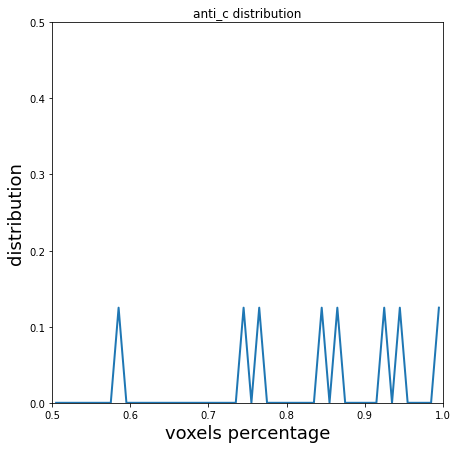

<Figure size 432x288 with 0 Axes>

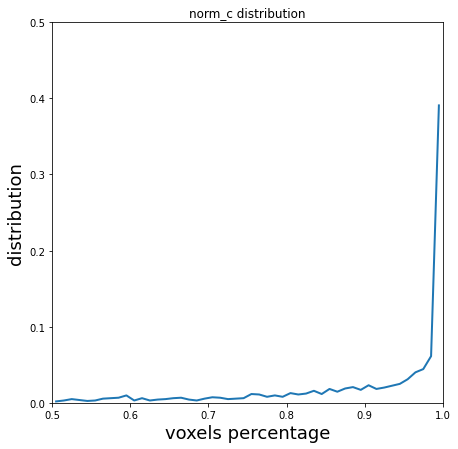

In [25]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/2D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/2D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [26]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 1 and 159
The ratio of anti-curvature voxels during whole simulations is 99.375% in 160 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 171231 and 176
The ratio of norm-curvature voxels during whole simulations is 99.89732041281862% in 171407 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 8
The ratio of anti-curvature and norm GBs during whole simulations is 0.4830917874396135% and 99.51690821256038% in 1656 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 1
The ratio of anti-curvature and norm GBs during whole simulations is 0.06038647342995169% and 38.88888888888889% in 1656 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) 0.00035584529270054553

all points fitting: 0.9359468602405758
all points slope: 2.770743019188883
smaller points fitting: 0.9075446911152127
smaller points slope: 2.947342002897959
1.9242792860618816


<Figure size 432x288 with 0 Axes>

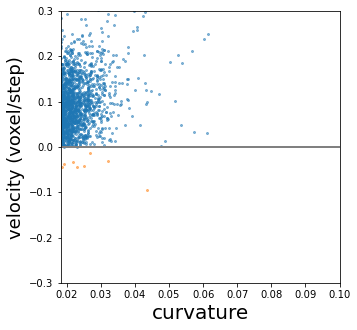

<Figure size 432x288 with 0 Axes>

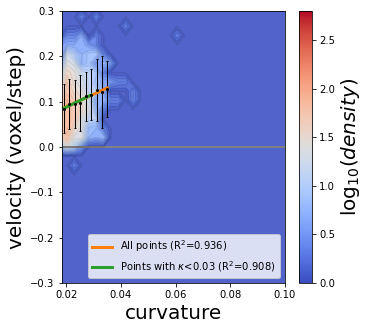

In [ ]:
    # =============================================================================
    # VISUALIZATION: VELOCITY-CURVATURE RELATIONSHIPS - MISORIENTATION-ONLY ANISOTROPY
    # =============================================================================
    
    # Create comprehensive velocity vs curvature scatter plots
    # For M-anisotropic systems, anti-curvature behavior is less pronounced than in full MI case
    # but more evident than in isotropic systems
    
    # Basic scatter plot: All GBs (normal and anti-curvature)
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)  # Zero velocity reference line
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5,label='Normal-curvature GBs')
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01',label='Anti-curvature GBs')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.105, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.4, 0.4, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plotting
    bin_interval = 0.002
    x_lim = [0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list+GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=2.8)
    ax2 = plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=2.8)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=2.8))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    
    # Linear fit for all valid bins
    x_all = curvature_coordinate[valid_bins]
    y_all = velocity_bin_means[valid_bins]
    p_all = np.polyfit(x_all, y_all, 1)
    y_pred_all = np.polyval(p_all, x_all)
    r2_all = 1 - np.sum((y_all - y_pred_all)**2) / np.sum((y_all - np.mean(y_all))**2)
    print(f"all points fitting: {r2_all}")
    print(f"all points slope: {p_all[0]}")
    
    # Linear fit for valid bins with curvature < 0.05
    mask_sub = x_all < 0.03
    x_sub = x_all[mask_sub]
    y_sub = y_all[mask_sub]
    if len(x_sub) > 1:
        p_sub = np.polyfit(x_sub, y_sub, 1)
        y_pred_sub = np.polyval(p_sub, x_sub)
        r2_sub = 1 - np.sum((y_sub - y_pred_sub)**2) / np.sum((y_sub - np.mean(y_sub))**2)
    else:
        r2_sub = np.nan
    print(f"smaller points fitting: {r2_sub}")
    print(f"smaller points slope: {p_sub[0]}")
    
    # Plot linear fits
    plt.plot(x_all, y_pred_all, '-', color='C1', linewidth=3, label=rf'All points (R$^2$={r2_all:.3f})')
    if len(x_sub) > 1:
        plt.plot(x_sub, y_pred_sub, '-', color='C2', linewidth=3, label=rf'Points with $\kappa$<0.03 (R$^2$={r2_sub:.3f})')
    plt.legend(loc='lower right')
    
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    print(np.max(np.log10(hist.T)))
    

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

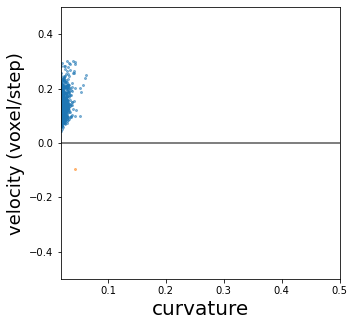

<Figure size 432x288 with 0 Axes>

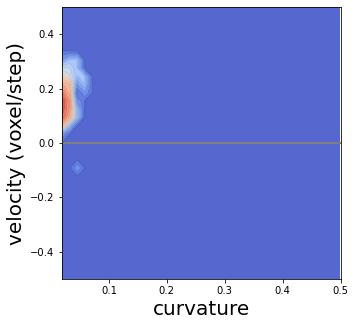

<Figure size 432x288 with 0 Axes>

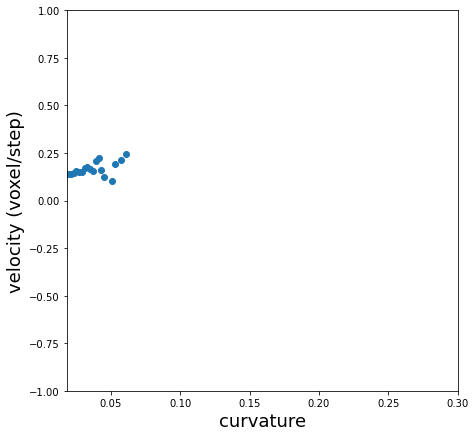

In [28]:
    # All in 1 figrue
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.505, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-0.6, 0.6, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-0.5,0.5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.002
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = update_GB_normc_list_area_list+update_GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_curvature_1Dlist_remove_0step[index])<=x_lim[0]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

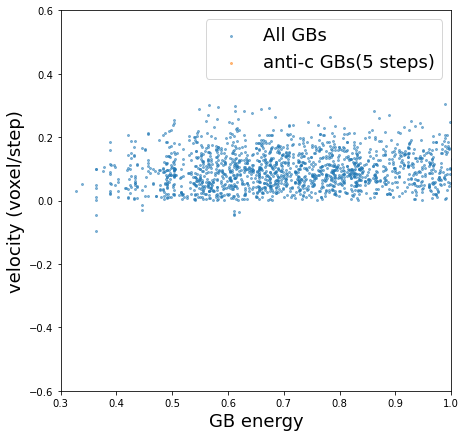

<Figure size 432x288 with 0 Axes>

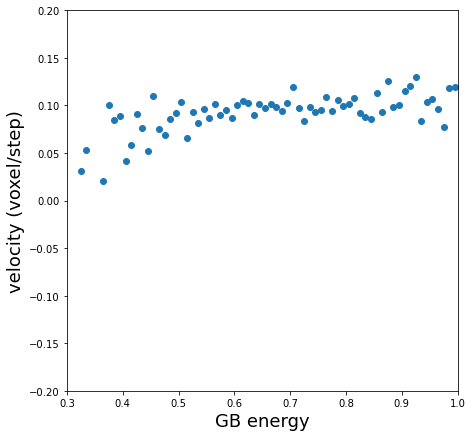

<Figure size 432x288 with 0 Axes>

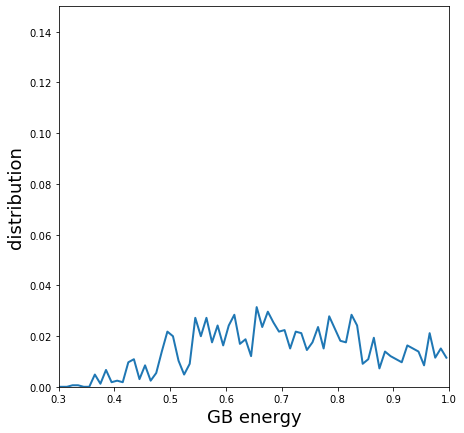

<Figure size 432x288 with 0 Axes>

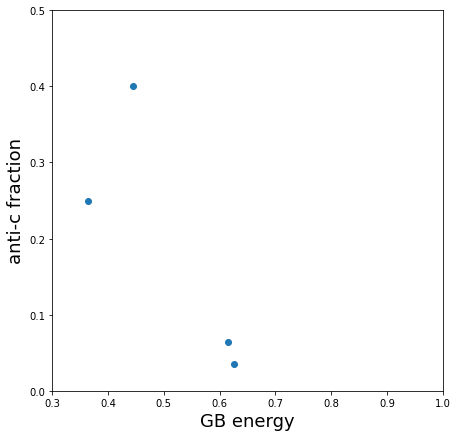

In [ ]:
    # =============================================================================
    # GRAIN BOUNDARY ENERGY ANALYSIS - MISORIENTATION-ONLY ANISOTROPY
    # =============================================================================
    
    # Analyze the relationship between GB energy and velocity for M-anisotropic systems
    # In misorientation-only anisotropy, energy varies with misorientation angle but not inclination
    # This creates energy landscape complexity intermediate between isotropic and full MI cases

    GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+ GB_antic_list_GBenergy_list
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list+ GB_antic_list_velocity_list
    
    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_list = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_list>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_list>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
        

<Figure size 432x288 with 0 Axes>

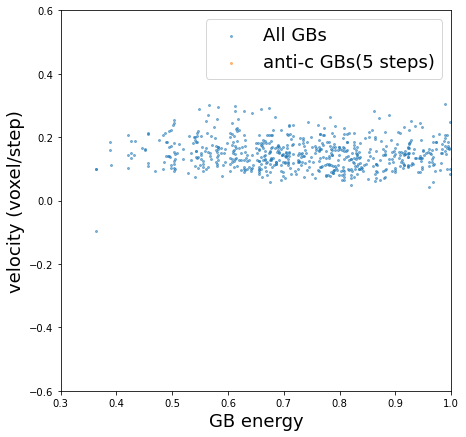

<Figure size 432x288 with 0 Axes>

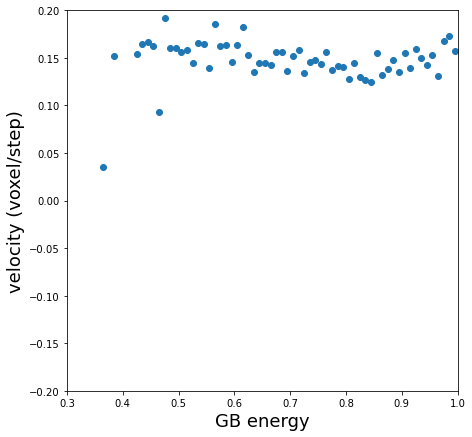

<Figure size 432x288 with 0 Axes>

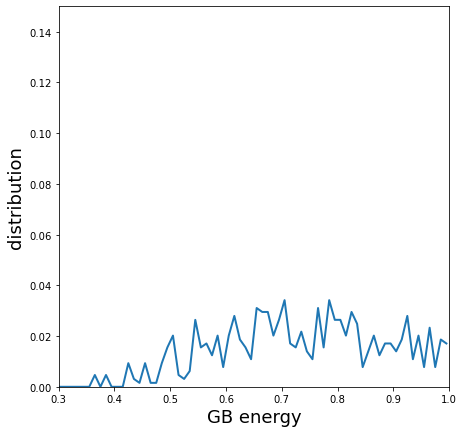

<Figure size 432x288 with 0 Axes>

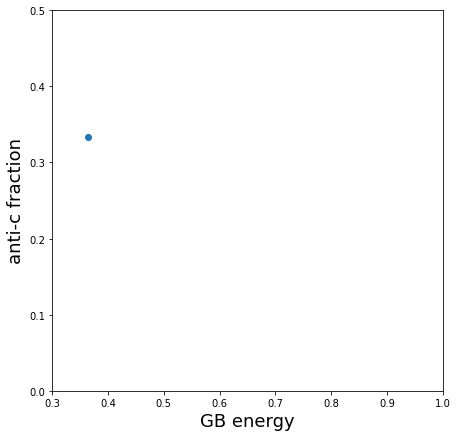

In [30]:

    figure_name_all = f"figures/2D_velocity_GBenergy_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(new_GBenergy_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    update_GB_antic_list_GBenergy_list = np.array(update_GB_antic_list_GBenergy_list)
    update_GB_antic_list_velocity_list = np.array(update_GB_antic_list_velocity_list)
    update_GB_antic_list_anticNum_list = np.array(update_GB_antic_list_anticNum_list)
    plt.scatter(update_GB_antic_list_GBenergy_list[update_GB_antic_list_anticNum_list>=5], update_GB_antic_list_velocity_list[update_GB_antic_list_anticNum_list>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_confi_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
#     GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
#     delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
#     mean_delta_n = np.mean(delta_n)
#     mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
#     print(mean_delta_n_2)
#     plt.figure()
#     fig = plt.figure(figsize=(7, 7))
#     plt.xlim([0.3,1.0])
#     plt.ylim([0,5])
#     plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
#     plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
#     plt.legend(fontsize=18)
#     plt.xlabel("GB energy", fontsize=18)
#     plt.ylabel("num of site", fontsize=18)
        

FloatingPointError: invalid value encountered in divide

<Figure size 432x288 with 0 Axes>

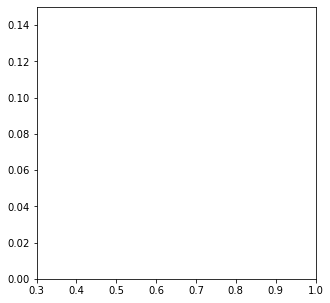

In [ ]:
    # =============================================================================
    # ENERGY DISTRIBUTION EVOLUTION ANALYSIS
    # =============================================================================
    
    # Compare energy distributions at different stages of grain growth
    # In M-anisotropic systems, energy distribution evolution shows intermediate behavior
    # between isotropic and fully anisotropic cases
    
    # Set up binning for energy distribution analysis
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    # Compare distributions between initial state (20k grains) and evolved state (1k grains)
    figure_name_distri = f"figures/2D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0  # Initial state with 20k grains
    second_step = step_1000grains  # Evolved state with ~1k grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/2D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Energy distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


In [ ]:
len(GB_list_GBenergy_list[8])

In [ ]:
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    GBenergy_bin = np.zeros(bin_number)
    GB_list_GBenergy_list_new = sum(GB_list_GBenergy_list, [])
    for index in range(len(GB_list_GBenergy_list_new)):
        if abs(GB_list_GBenergy_list_new[index])>=1.0: continue
        GBenergy_bin[int((GB_list_GBenergy_list_new[index]-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_all_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/2D_culmmulative_distribution_function_all_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    culmmulative_GBenergy_bin = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin[i] = np.sum(GBenergy_bin[:i+1]/np.sum(GBenergy_bin))
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin,'-', linewidth=2)
    # plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("culmmulative distribution function", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')

# =============================================================================
# SINGLE TIME STEP ANALYSIS - MISORIENTATION-ONLY ANISOTROPY
# =============================================================================

## Analysis of specific grain size state

This section analyzes grain boundary behavior at a specific time step when the system has reached approximately 5000 grains. In misorientation-only anisotropic systems, this provides insight into how anti-curvature behavior manifests at intermediate grain sizes, between the fully anisotropic MI case and the isotropic baseline.

In [ ]:
    # =============================================================================
    # SINGLE GRAIN COUNT ANALYSIS
    # =============================================================================
    
    # Analyze grain boundary behavior at a specific grain count for detailed examination
    # In M-anisotropic systems, intermediate grain sizes show distinct energy-velocity relationships

    # get expected time step
    expected_grain_num = 5000
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    # Calculate the number of grains
    for i in tqdm(range(npy_file_aniso.shape[0])):
        grain_num = len(np.unique(npy_file_aniso[i,:]))
        grain_num_array[i] = grain_num
        if grain_num < expected_grain_num/2: break
    expected_time_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))

    # get all data on specific grain step
    expected_step_curvature_list = GB_list_curvature_list[expected_time_step]
    expected_step_velocity_list = GB_list_velocity_list[expected_time_step]
    expected_step_GBenergy_list = GB_list_GBenergy_list[expected_time_step]
    expected_step_curvature_list_exrandom = GB_list_curvature_list_exrandom[expected_time_step]
    expected_step_velocity_list_exrandom = GB_list_velocity_list_exrandom[expected_time_step]
    expected_step_GBenergy_list_exrandom = GB_list_GBenergy_list_exrandom[expected_time_step]

    # plot
    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d_grain{expected_grain_num}.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(expected_step_GBenergy_list_exrandom, expected_step_velocity_list_exrandom,s=4,alpha=0.5,label='All GBs')
    # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    # plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.005
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    
    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(expected_step_GBenergy_list_exrandom)):
        if abs(expected_step_GBenergy_list_exrandom[index])>=1.01: continue
        GBenergy_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += expected_step_velocity_list_exrandom[index]
        if expected_step_velocity_list_exrandom[index] < 0: antic_num_bin[int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)] += 1
        if int((expected_step_GBenergy_list_exrandom[index]-x_lim[0])//bin_interval)<0: print(expected_step_GBenergy_list_exrandom[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin_grain{expected_grain_num}.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.3])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)

    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)

    anti_c_data_file_name = f"data/2D_antic_data_{case_name}_grain{expected_grain_num}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)



In [94]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

The longest anti-curvature behavior is 135601364 with steps 19
The anti-curvature step 8 has velocity - -0.018 and curvature - 0.038.
The anti-curvature step 10 has velocity - -0.04 and curvature - 0.018.
The anti-curvature step 12 has velocity - -0.03 and curvature - 0.016.
The anti-curvature step 14 has velocity - -0.016 and curvature - 0.001.
The anti-curvature step 15 has velocity - -0.047 and curvature - 0.009.
The anti-curvature step 19 has velocity - -0.112 and curvature - 0.018.
The anti-curvature step 21 has velocity - -0.055 and curvature - 0.009.
The anti-curvature step 24 has velocity - -0.008 and curvature - 0.007.
The anti-curvature step 25 has velocity - -0.055 and curvature - 0.007.
The anti-curvature step 29 has velocity - -0.018 and curvature - 0.013.
The anti-curvature step 31 has velocity - -0.025 and curvature - 0.024.
The anti-curvature step 33 has velocity - -0.067 and curvature - 0.036.
The anti-curvature step 34 has velocity - -0.009 and curvature - 0.013.
The 

Text(0.5, 1.0, 'GBid 135601364 step all')

<Figure size 432x288 with 0 Axes>

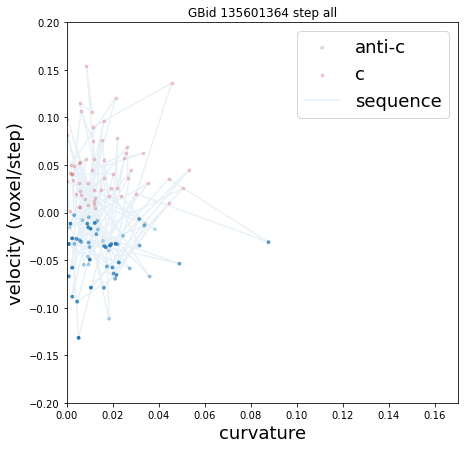

In [17]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [212]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

In [213]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [136]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [50]:
# # Plot more information for a focus GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [51]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [52]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')